Best energy found: -6


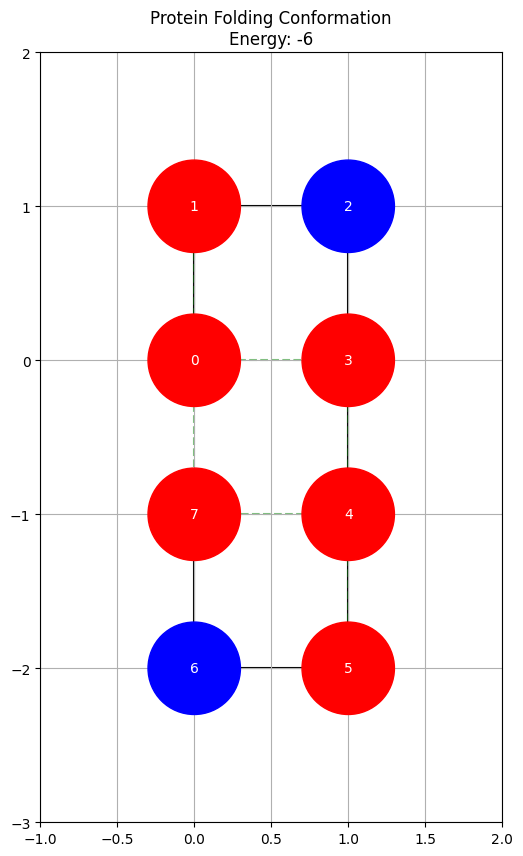

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from matplotlib.patches import Rectangle

class ProteinFolding:
    def __init__(self, sequence):
        """Initialize with HP sequence (H: hydrophobic, P: polar)"""
        self.sequence = sequence
        self.directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up
        self.best_conformation = None
        self.best_energy = float('inf')
        
    def is_valid_move(self, coords, pos):
        """Check if a new position conflicts with existing amino acids"""
        return pos not in coords
        
    def calculate_energy(self, coords):
        """Calculate energy based on H-H contacts (simplified energy model)"""
        energy = 0
        h_positions = [pos for i, pos in enumerate(coords) if self.sequence[i] == 'H']
        
        for i, pos1 in enumerate(h_positions):
            for pos2 in h_positions[i+1:]:
                # Check if positions are adjacent but not connected in sequence
                dx = abs(pos1[0] - pos2[0])
                dy = abs(pos1[1] - pos2[1])
                if dx + dy == 1:  # Adjacent positions
                    energy -= 1  # Decrease energy for each H-H contact
                    
        return energy
        
    def monte_carlo_fold(self, iterations=1000, temperature=1.0):
        """Use Monte Carlo simulation to find low-energy conformations"""
        # Initialize with straight line conformation
        current_coords = [(0, i) for i in range(len(self.sequence))]
        current_energy = self.calculate_energy(current_coords)
        
        self.best_conformation = current_coords[:]
        self.best_energy = current_energy
        
        for step in range(iterations):
            # Choose a random pivot point
            pivot = random.randint(1, len(self.sequence)-2)
            
            # Create new conformation by rotating the end portion
            new_coords = current_coords[:pivot+1]
            relative_pos = (0, 0)
            
            # Randomly choose new direction for the chain after pivot
            current_dir = random.choice(self.directions)
            
            # Build the rest of the chain
            valid = True
            for i in range(pivot+1, len(self.sequence)):
                new_pos = (new_coords[pivot][0] + relative_pos[0] + current_dir[0],
                          new_coords[pivot][1] + relative_pos[1] + current_dir[1])
                
                if not self.is_valid_move(new_coords, new_pos):
                    valid = False
                    break
                    
                new_coords.append(new_pos)
                relative_pos = (relative_pos[0] + current_dir[0],
                              relative_pos[1] + current_dir[1])
                
            if not valid:
                continue
                
            # Calculate new energy
            new_energy = self.calculate_energy(new_coords)
            
            # Accept or reject new conformation based on Metropolis criterion
            delta_energy = new_energy - current_energy
            if delta_energy < 0 or random.random() < np.exp(-delta_energy / temperature):
                current_coords = new_coords
                current_energy = new_energy
                
                # Update best conformation if necessary
                if current_energy < self.best_energy:
                    self.best_energy = current_energy
                    self.best_conformation = current_coords[:]
                    
        return self.best_conformation, self.best_energy
    
    def visualize(self, coords=None, show_energy=True):
        """Visualize the protein conformation"""
        if coords is None:
            coords = self.best_conformation
            
        if coords is None:
            raise ValueError("No conformation available to visualize")
            
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot the chain
        xs, ys = zip(*coords)
        plt.plot(xs, ys, 'k-', zorder=1)
        
        # Plot amino acids
        for i, (x, y) in enumerate(coords):
            color = 'red' if self.sequence[i] == 'H' else 'blue'
            circle = plt.Circle((x, y), 0.3, color=color, zorder=2)
            ax.add_artist(circle)
            plt.text(x, y, str(i), color='white', 
                    horizontalalignment='center', verticalalignment='center')
            
        # Add H-H contacts visualization
        h_positions = [pos for i, pos in enumerate(coords) if self.sequence[i] == 'H']
        for i, pos1 in enumerate(h_positions):
            for pos2 in h_positions[i+1:]:
                dx = abs(pos1[0] - pos2[0])
                dy = abs(pos1[1] - pos2[1])
                if dx + dy == 1:  # Adjacent positions
                    mid_x = (pos1[0] + pos2[0]) / 2
                    mid_y = (pos1[1] + pos2[1]) / 2
                    plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 
                            'g--', alpha=0.5, zorder=1)
        
        if show_energy:
            energy = self.calculate_energy(coords)
            plt.title(f'Protein Folding Conformation\nEnergy: {energy}')
        
        plt.grid(True)
        ax.set_aspect('equal')
        plt.xlim(min(xs) - 1, max(xs) + 1)
        plt.ylim(min(ys) - 1, max(ys) + 1)
        plt.show()

def main():
    # Example HP sequence (H: hydrophobic, P: polar)
    sequence = "HHPHHHPH"
    
    # Create protein folding simulator
    protein = ProteinFolding(sequence)
    
    # Run Monte Carlo simulation
    best_conformation, best_energy = protein.monte_carlo_fold(
        iterations=5000, 
        temperature=0.5
    )
    
    print(f"Best energy found: {best_energy}")
    
    # Visualize the result
    protein.visualize()

if __name__ == "__main__":
    main()